In [11]:
REPO_ROOT = "/usr/src/app"

import collections
import json
import math
import random

import numpy as np
import tensorflow as tf

import util
reload(util)

<module 'util' from 'util.py'>

In [82]:
BATCH_SIZE = 100
VOCAB_SIZE = 5000
EMBEDDING_SIZE = 400

TRAIN_SIZE = 1600
VALIDATE_SIZE = 200
TEST_SIZE = 200

In [3]:
with open("%s/scripts/table_flag.json" % REPO_ROOT) as f:
    data_table = json.load(f)

In [12]:
counts = collections.Counter()
print "Tokenizing %d scripts..." % len(data_table)
for idx, script in enumerate(data_table):
    if idx % 50000 == 0:
        print "%d done." % idx

    if idx % 15 != 0:
        continue
        
    with open("%s/scripts/%s.js" % (REPO_ROOT, script["sha"])) as f:
        js = f.read()
        tokens = util.tokenize_js(js)
        counts.update(tokens)

Tokenizing 530219 scripts...
0 done.
50000 done.
100000 done.
150000 done.
200000 done.
250000 done.
300000 done.
350000 done.
400000 done.
450000 done.
500000 done.


In [13]:
for token, count in counts.most_common(100):
    print "%s: %d" % (token, count)

x: 28331104
.: 17854468
): 15889942
(: 15881514
,: 14330459
{: 5235564
}: 5222394
this: 3327989
function: 2591177
+: 2453384
0: 1974836
var: 1716943
return: 1683651
if: 1532860
1: 1023792
*: 856729
length: 573219
null: 515592
for: 405828
"": 400338
/: 378967
else: 296355
typeof: 276250
_: 266460
options: 264958
new: 257706
prototype: 248212
data: 230699
2: 229309
type: 220031
document: 209109
push: 208428
element: 200757
call: 196802
value: 194601
window: 182624
event: 181193
jquery: 173435
in: 173305
style: 172981
true: 172158
false: 170870
css: 165436
arguments: 154529
test: 153669
each: 145340
width: 140208
name: 138629
void: 136536
-1: 133379
height: 127944
elem: 127732
attr: 126929
id: 126758
3: 126673
find: 125222
replace: 123812
fn: 122214
math: 121779
get: 119299
nodetype: 118291
left: 116905
top: 114701
break: 112558
extend: 109403
apply: 104481
" ": 100488
parentnode: 97412
indexof: 97086
case: 93813
target: 93354
-: 89724
the: 88561
addclass: 85638
opts: 82470
tolowercase: 8

In [14]:
word_table = {
    entry[0]: idx
    for idx, entry in enumerate(counts.most_common(VOCAB_SIZE-1))
}
def numerize(word):
    return word_table.get(word, VOCAB_SIZE-1)

In [64]:
def embedding_graph(batch_size, vocabulary_size, embedding_size):
    graph = tf.Graph()

    with graph.as_default():    
        embeddings = tf.Variable(
            tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0),
            name="word_embeddings")
        
        norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
        normalized_embeddings = embeddings / norm

        nce_weights = tf.Variable(
          tf.truncated_normal([vocabulary_size, embedding_size],
                              stddev=1.0 / math.sqrt(embedding_size)))
        nce_biases = tf.Variable(tf.zeros([vocabulary_size]))

        x_ph = tf.placeholder(tf.int32, shape=[batch_size])
        y_ph = tf.placeholder(tf.int32, shape=[batch_size,1])

        embed = tf.nn.embedding_lookup(embeddings, x_ph)

        # Compute the NCE loss, using a sample of the negative labels each time.
        loss = tf.reduce_mean(
            tf.nn.nce_loss(nce_weights, nce_biases, embed, y_ph,
                           64, vocabulary_size))
        
        output = tf.transpose(tf.matmul(nce_weights, tf.transpose(embed))) + nce_biases
        y_pred = tf.argmax(tf.nn.softmax(output), 1)

        optimizer = tf.train.GradientDescentOptimizer(learning_rate=1.0).minimize(loss)
    
    return graph, x_ph, y_ph, embeddings, normalized_embeddings, optimizer, loss, y_pred

In [83]:
random.seed(9812)
indices = random.sample(range(len(data_table)), TRAIN_SIZE + VALIDATE_SIZE + TEST_SIZE)
train_indices = indices[:TRAIN_SIZE]
validate_indices = indices[TRAIN_SIZE:-TEST_SIZE]
test_indices = indices[-TEST_SIZE:]

def generate_batch(indices, sample_ratio):
    x = np.ndarray(shape=(BATCH_SIZE), dtype=np.int32)
    y = np.ndarray(shape=(BATCH_SIZE,1), dtype=np.int32)
    batch_idx = 0
    for index in indices:
        with open("%s/scripts/%s.js" % (REPO_ROOT, script["sha"])) as f:
            js = f.read()
            tokens = [numerize(token) for token in util.tokenize_js(js)]
            for pos in random.sample(range(len(tokens)-1), int(math.floor(len(tokens)*sample_ratio))):
                x[batch_idx] = tokens[pos]
                y[batch_idx,0] = tokens[pos+1]
                batch_idx += 1
                if batch_idx == BATCH_SIZE:
                    yield x, y
                    batch_idx = 0

graph, x_ph, y_ph, embeddings, normalized_embeddings, optimizer, loss, y_pred = (
    embedding_graph(BATCH_SIZE, VOCAB_SIZE, EMBEDDING_SIZE))

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    
    batch_idx = 1
    average_loss = 0
    for inputs, labels in generate_batch(train_indices, 0.1):
        _, cur_loss = session.run([optimizer, loss], feed_dict={x_ph: inputs, y_ph: labels})
        average_loss += cur_loss
        
        if batch_idx % 2000 == 0:
            validate_batches = 0
            average_accuracy = 0
            for inputs2, labels2 in generate_batch(validate_indices, 0.01):
                predicted_labels = session.run([y_pred], feed_dict={x_ph: inputs2})
                predicted_labels = np.transpose(predicted_labels)
                average_accuracy += (float(np.count_nonzero(labels2 == predicted_labels)) / BATCH_SIZE)
                validate_batches += 1
            
            print "%d Loss: %f, Accuracy: %f" % (batch_idx, average_loss / 1999, average_accuracy / validate_batches)
            average_loss = 0
            
        batch_idx += 1
        
    final_embeddings = normalized_embeddings.eval()
    
print "Done training."

2000 Loss: 16.950221, Accuracy: 0.000799
4000 Loss: 2.970565, Accuracy: 0.354253
6000 Loss: 2.868888, Accuracy: 0.284124
8000 Loss: 2.856695, Accuracy: 0.414124
10000 Loss: 2.847942, Accuracy: 0.350361
12000 Loss: 2.841311, Accuracy: 0.414253
14000 Loss: 2.829604, Accuracy: 0.380515
16000 Loss: 2.816063, Accuracy: 0.399485
18000 Loss: 2.815174, Accuracy: 0.379562
20000 Loss: 2.800092, Accuracy: 0.333376
22000 Loss: 2.804750, Accuracy: 0.307758
24000 Loss: 2.805353, Accuracy: 0.421649
26000 Loss: 2.799364, Accuracy: 0.366366
28000 Loss: 2.792710, Accuracy: 0.404871
30000 Loss: 2.804127, Accuracy: 0.388763
Done training.


In [84]:
from sklearn.manifold import TSNE
model = TSNE(n_components=2, random_state=0)
points = model.fit_transform(final_embeddings)

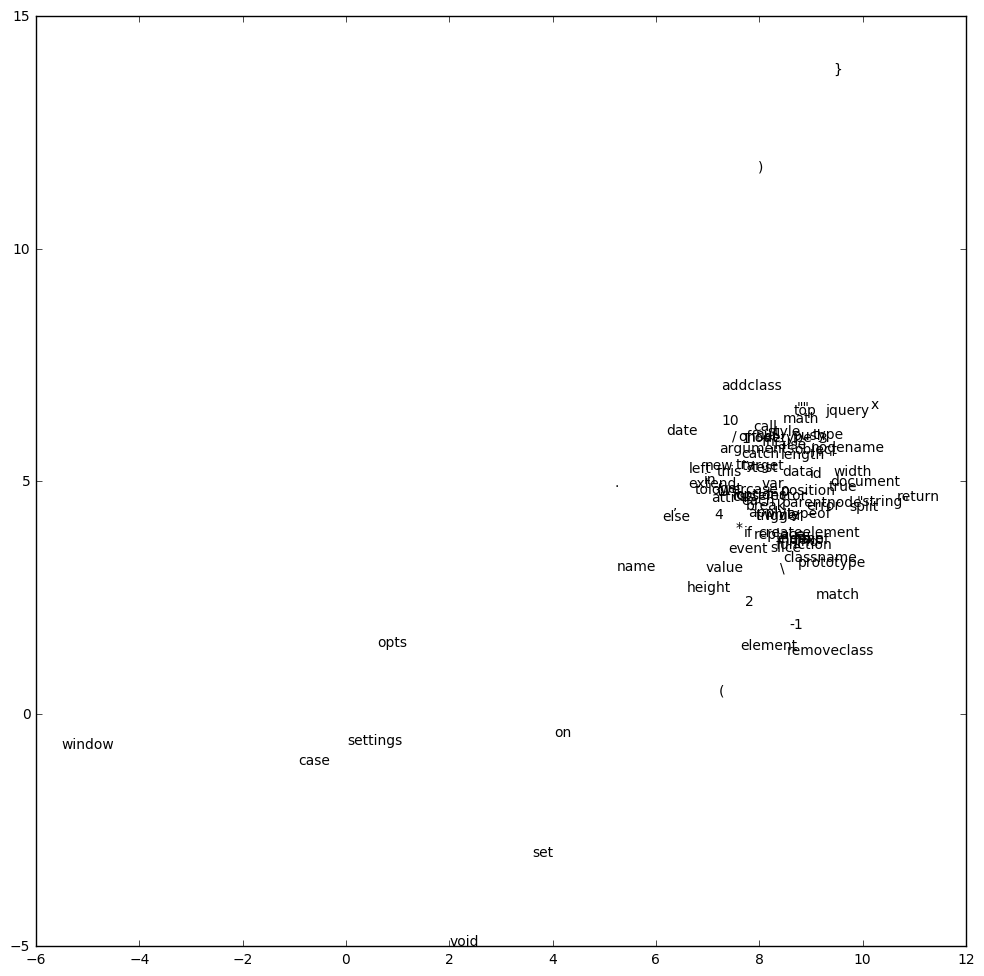

In [85]:
%matplotlib inline
import matplotlib.pyplot as plt

words = [entry[0] for entry in counts.most_common(VOCAB_SIZE-1)] + ["UNK"]

fig, ax = plt.subplots(figsize=(12, 12))
ax.plot(points[:100,0], points[:100,1], 'bo', markersize=0)

for i, txt in enumerate(words[:100]):
    ax.annotate(txt, (points[i][0],points[i][1]))